# K-Means

## Initialization

The first thing we do for each algorithm will be to try to use it without thinking, just decide a subset of feature based on the undestanding and analysis.

In [160]:
# As always we start by importing the necessary libraries
# and loading the data we will be working with.
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# this is a classic
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from utility.cluster_utility import scale_data, inverse_scale_data
from utility.cluster_utility import k_search


# we define a random state to make the results reproducible
RANDOM_STATE = 42
RUN_SLOW_STUFF = True

cyclysts_df = pd.read_csv('../dataset/cyclists_cleaned.csv')
print(cyclysts_df.columns)

Index(['_url', 'name', 'birth_year', 'weight', 'height', 'nationality', 'bmi',
       'race_count', 'experience_level', 'total_points', 'victories_by_points',
       'avg_points_per_race', 'average_position', 'avg_speed_cyclist',
       'cyclist_age', 'cyclist', 'stamina_index'],
      dtype='object')


Now we decide on which features we can do the clustering

**TODO** Read the markdown comment (not if you are a professor please)
<!-- ??It is important for clustering to do not use binary/cathegorical feature?? -->
<!-- ??Should we consider splitting in training and validation?? -->
<!-- Should we study theory before start programming?
    Yes for sure, but we don't have much time :( -->

In [161]:
# We will start by keeping all the numerical columns and see where this brings us.
cyclysts_df = cyclysts_df.select_dtypes(include=[np.number])
# drop the rows with missing values
initial_count = cyclysts_df.shape[0]
cyclysts_df = cyclysts_df.dropna()
final_count = cyclysts_df.shape[0]
print(f'Dropped {initial_count - final_count} rows with missing values')
print(f'In percentage: {(initial_count - final_count) / initial_count * 100}%')
print(cyclysts_df.columns)

Dropped 3227 rows with missing values
In percentage: 52.6084121291164%
Index(['birth_year', 'weight', 'height', 'bmi', 'race_count', 'total_points',
       'victories_by_points', 'avg_points_per_race', 'average_position',
       'avg_speed_cyclist', 'cyclist_age', 'stamina_index'],
      dtype='object')


Probably we want to remove columns with too high correlation, for example it may not be a good idea to have: weight, height, and bmi

## Normalization

In [162]:
cyc_normalizer, cyc_normalized = scale_data(cyclysts_df)

## Hyperparameter

Now we do the classic plot with the various k 

_Warning_: it is obviously slow, but what can I do?

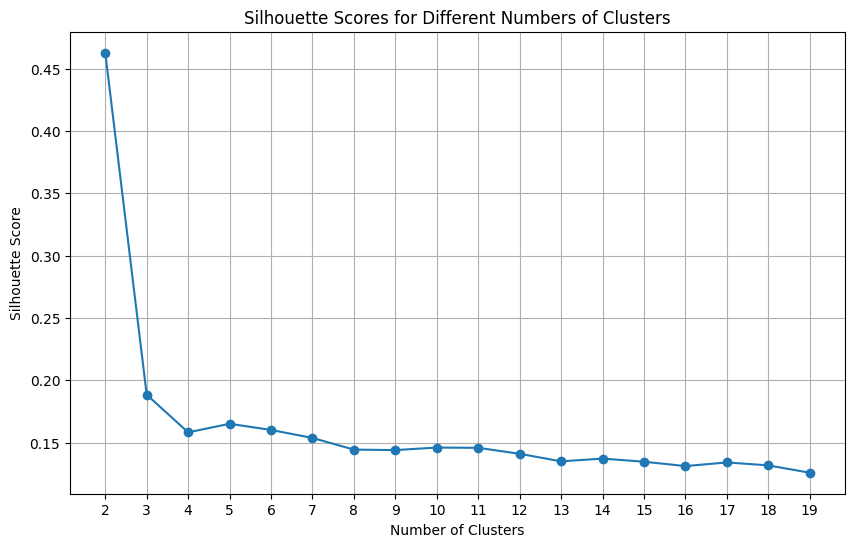

In [163]:
MAX_CLUSTERS = 20   # all the cluster numbers we want to try (from 2 to MAX_CLUSTERS)
N_INIT = 10         # Number of time the k-means algorithm will be run with different centroid seeds.
if RUN_SLOW_STUFF:
    silhouettes = k_search(max_clusters=MAX_CLUSTERS, n_init=N_INIT, data=cyc_normalized, init_method='random')

    # Plot the silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, MAX_CLUSTERS), silhouettes, marker='o')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.xticks(range(2, MAX_CLUSTERS))  # Set x-axis ticks to be integers
    plt.grid(True)
    plt.show()

## Analysis of the best result

Based on magic we can say that 4 is a good number of clusters. So we try to rerun the algorithm with the best parameters and then we will be able to analize a bit the results

In [164]:
kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init=N_INIT, init='random')
kmeans.fit(cyc_normalized)
cyclysts_df['cluster'] = kmeans.labels_
#sns.scatterplot(data=cyclysts_df, x="total_points", y="weight", hue=kmeans.labels_)

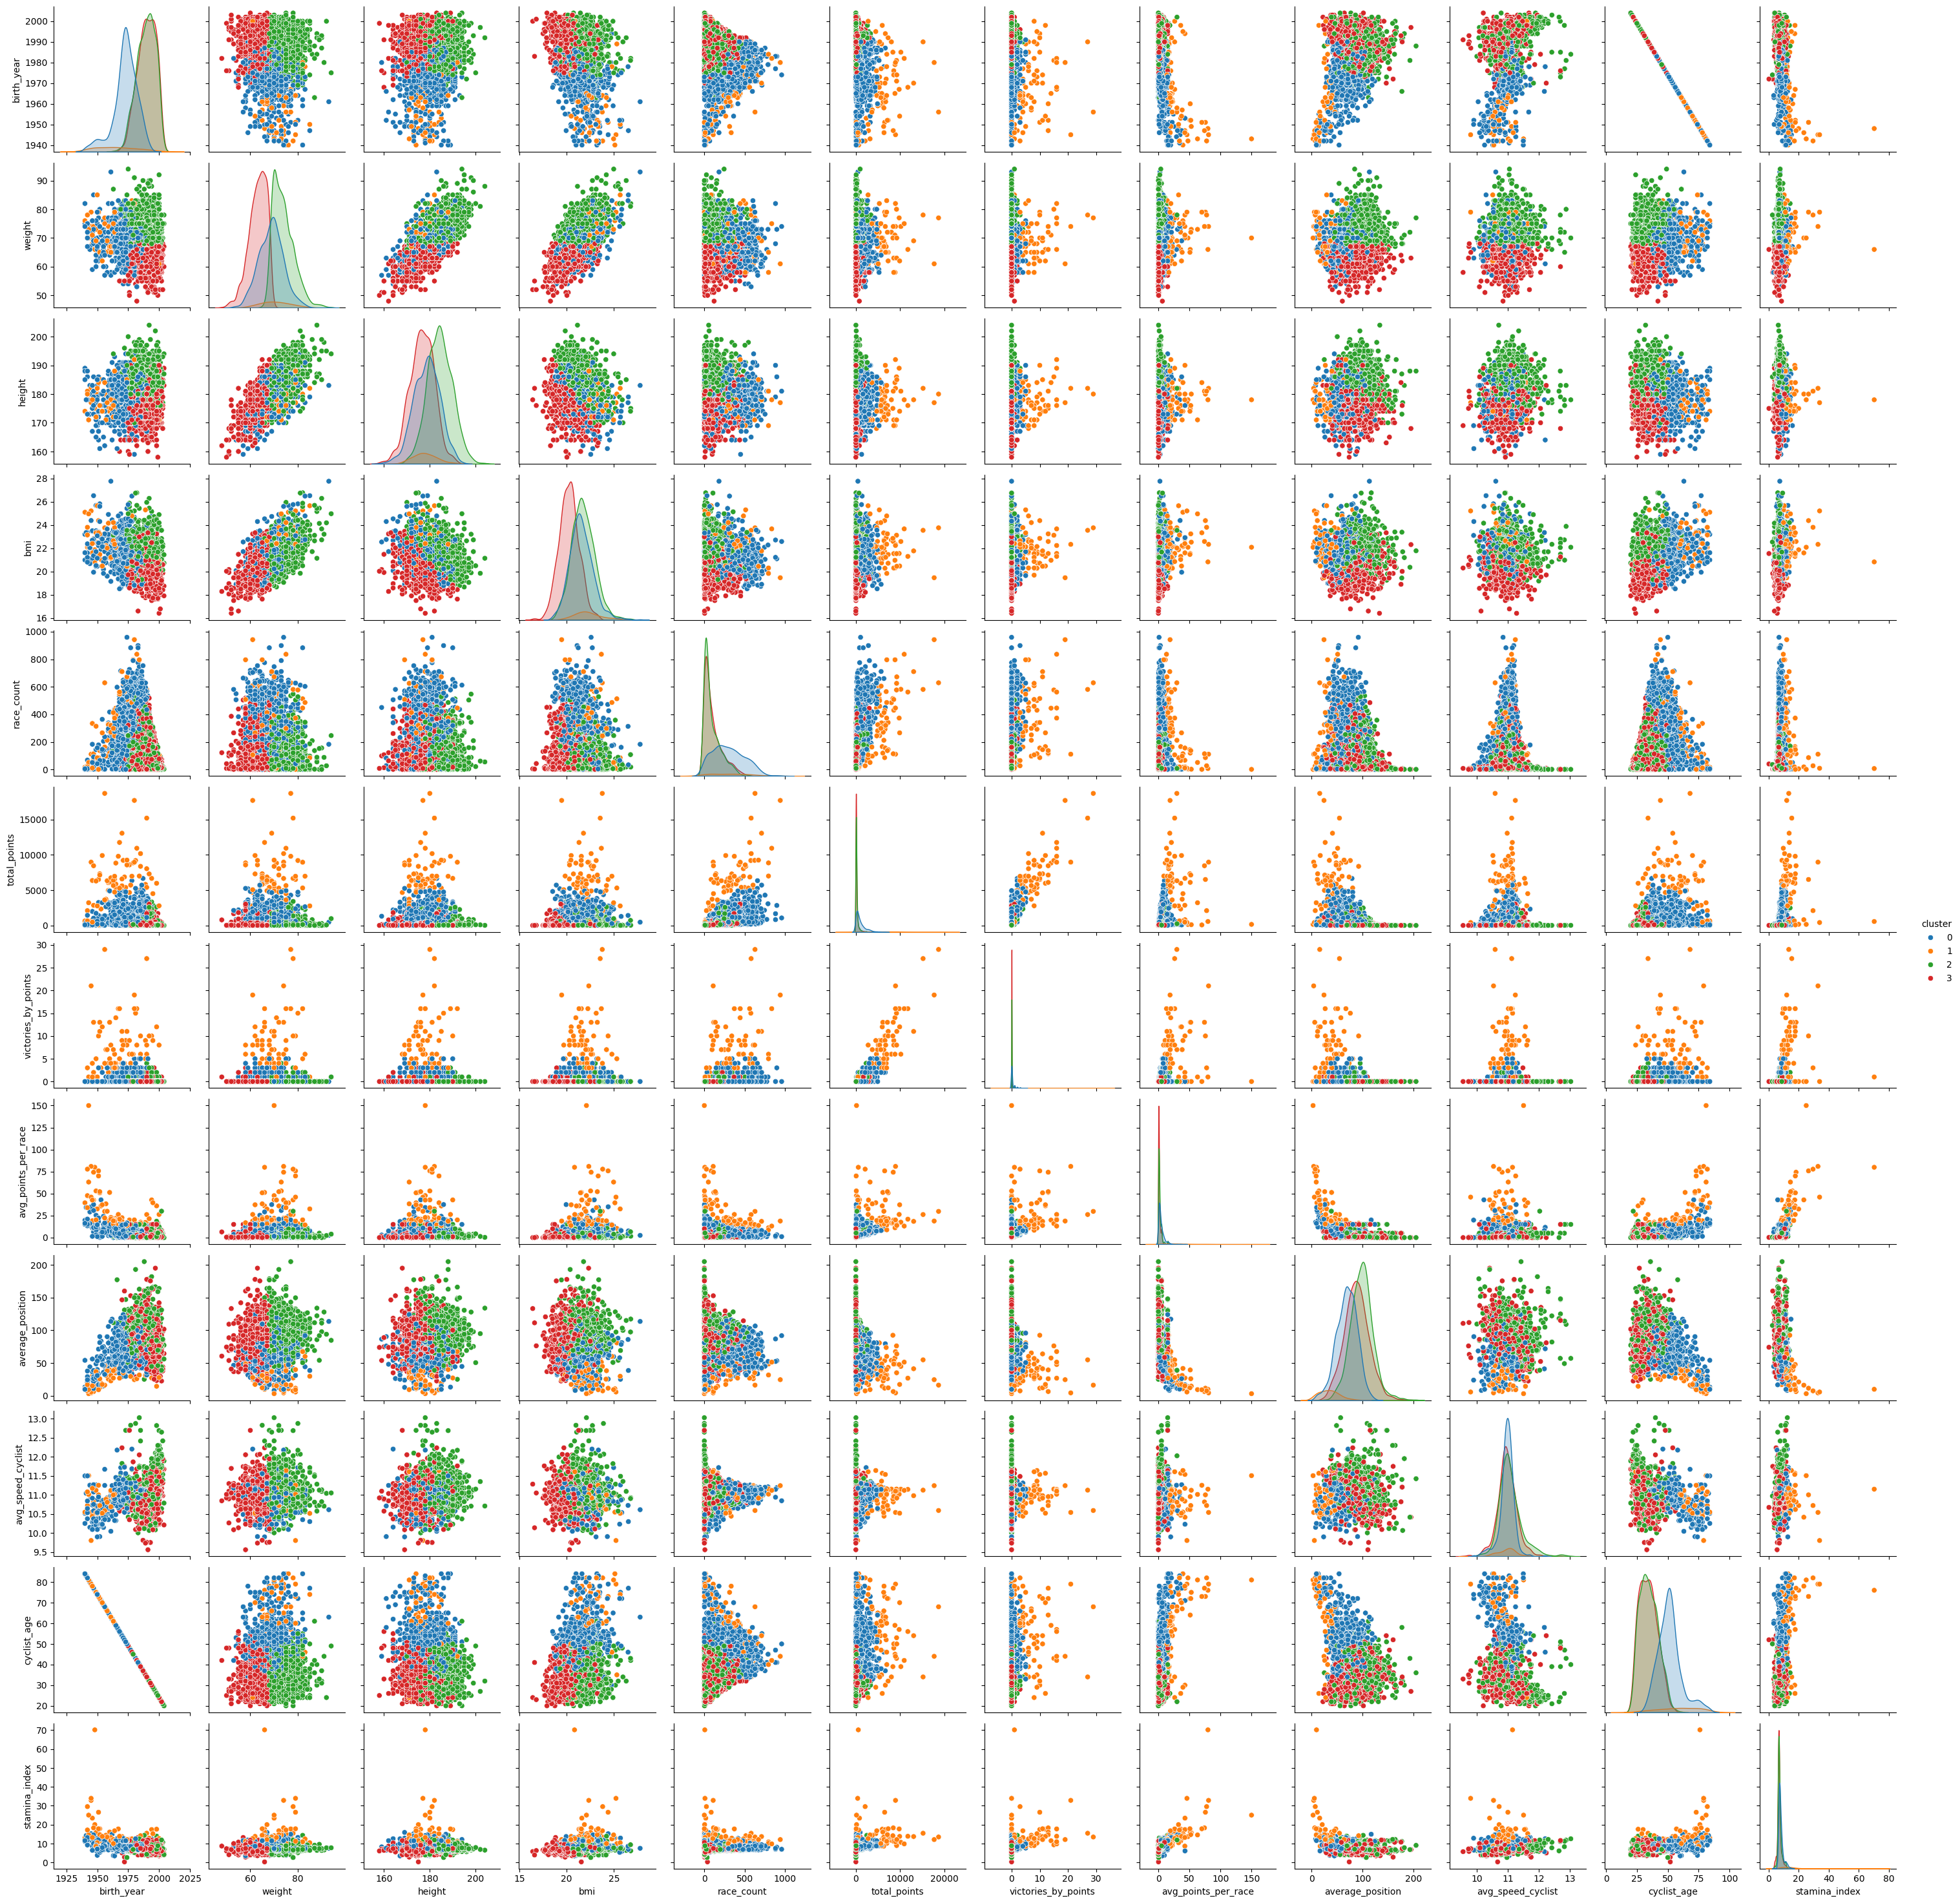

In [165]:
sns.pairplot(cyclysts_df, hue='cluster', palette='tab10')
plt.show()


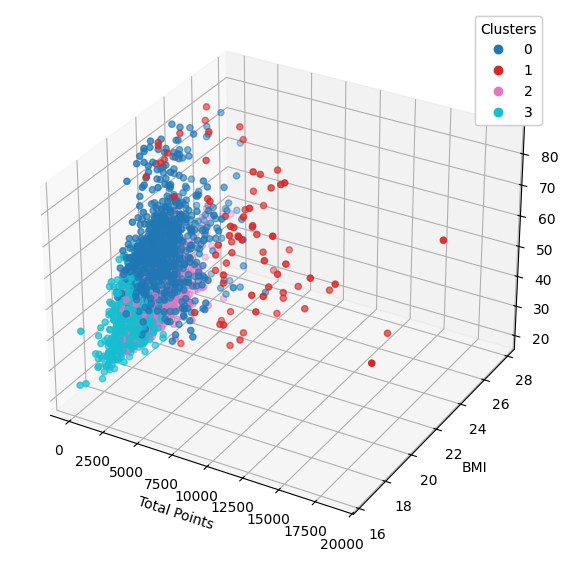

In [166]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(cyclysts_df['total_points'], cyclysts_df['bmi'], cyclysts_df['cyclist_age'], c=cyclysts_df['cluster'], cmap='tab10')

# Labels
ax.set_xlabel('Total Points')
ax.set_ylabel('BMI')
ax.set_zlabel('Height')

# Legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

The analysis looks impossible; probably we should remove the outliers of total points because the only meaningful division seems to be that one. But also we will try to remove some redundant columns

**Note** The above one is an old analysis, while still true, the fact that some cyclist that have higher points are in a different cluster wrt the "normal people" is kinda of interesting because they can be considered belonging to the "expert" class

## Improvements based on outcome

In this section we still use the classic base, kmeans with no fancy initializaiton but we select fewer columns to analize (removing the more dependent ones), in the following sessions other approaches will be tested and compared to this one

In [167]:
columns_to_remove = ['height', 'weight', 
                    'victories_by_points', 'avg_points_per_race', 'average_position',
                    'birth_year', # I forgot age was dependent from this and I was puzled by the presence of a straight line
                    'cluster'
]
# there is someone with super high stamina index, let's remove them
print(f'removing {cyclysts_df[cyclysts_df['stamina_index'] > 20].shape[0]} rows')
cyclysts_df = cyclysts_df[cyclysts_df['stamina_index'] < 20]
small_cyc_df = cyclysts_df.drop(columns=columns_to_remove)
cyc_normalizer, cyc_normalized = scale_data(small_cyc_df)
print(small_cyc_df.columns)

removing 8 rows
Index(['bmi', 'race_count', 'total_points', 'avg_speed_cyclist', 'cyclist_age',
       'stamina_index'],
      dtype='object')


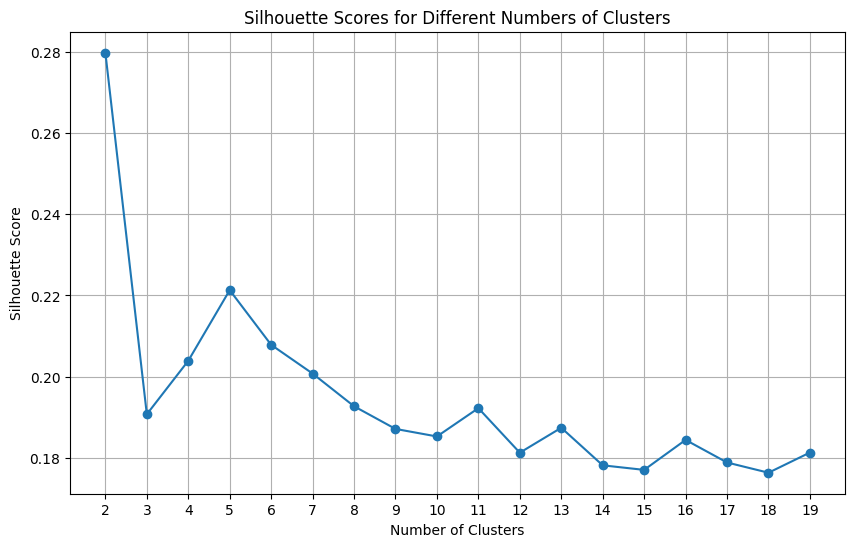

In [168]:
MAX_CLUSTERS = 20   # all the cluster numbers we want to try (from 2 to MAX_CLUSTERS)
N_INIT = 15         # Number of time the k-means algorithm will be run with different centroid seeds.
if RUN_SLOW_STUFF:
    silhouettes = k_search(max_clusters=MAX_CLUSTERS, n_init=N_INIT, data=cyc_normalized)

    # Plot the silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, MAX_CLUSTERS), silhouettes, marker='o')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.xticks(range(2, MAX_CLUSTERS))  # Set x-axis ticks to be integers
    plt.grid(True)
    plt.show()

Boh... 4/5/6?
cambia ogni volta che tolgo una feature (adesso e' 3)

**TODO**: check it is still 4 when sending the project to the professors

In [169]:
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=N_INIT, init='random')
kmeans.fit(cyc_normalized)
small_cyc_df['cluster'] = kmeans.labels_

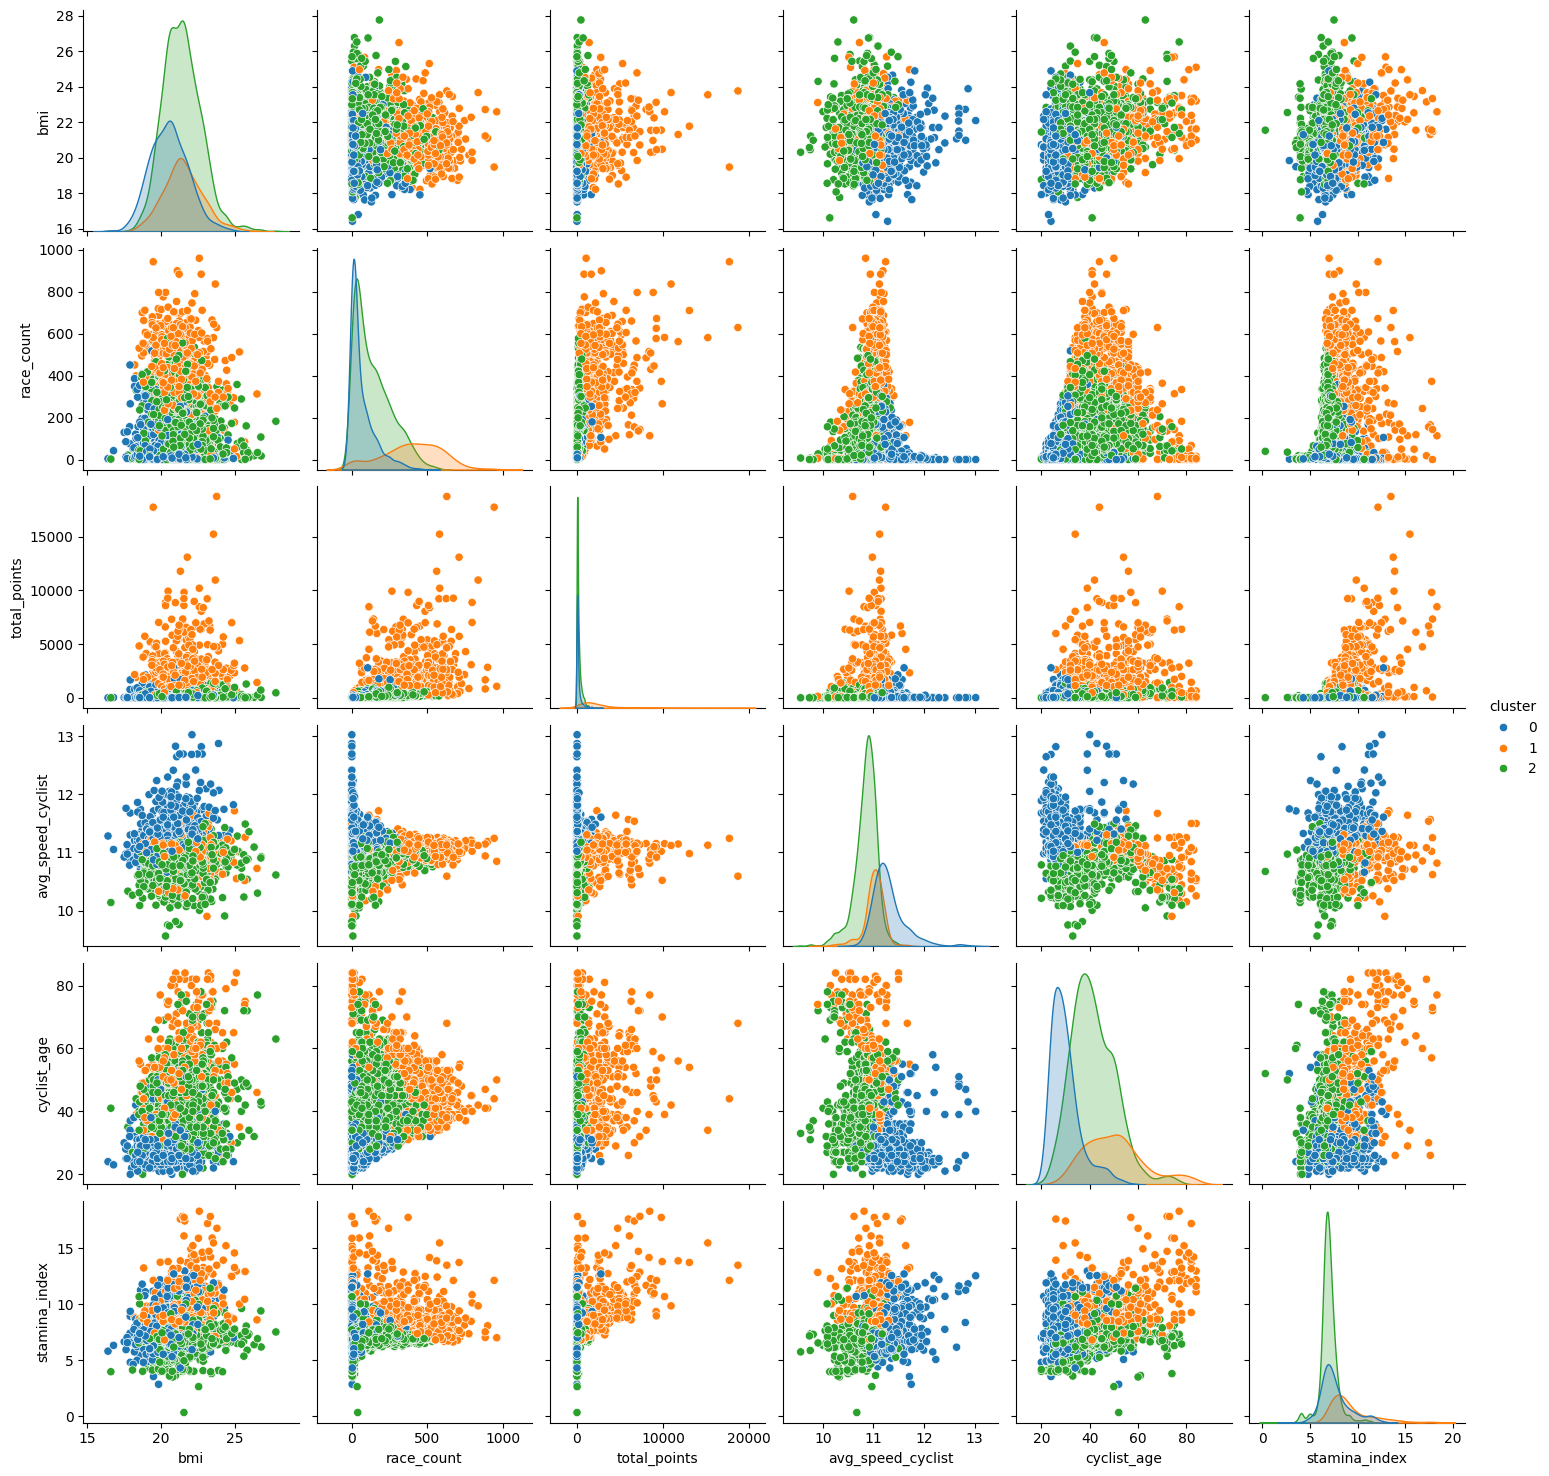

In [170]:
# Inverse transform the cluster centers
centers = cyc_normalizer.inverse_transform(kmeans.cluster_centers_)

# Pairplot with centers
pairplot = sns.pairplot(small_cyc_df, hue='cluster', palette='tab10')
plt.show()

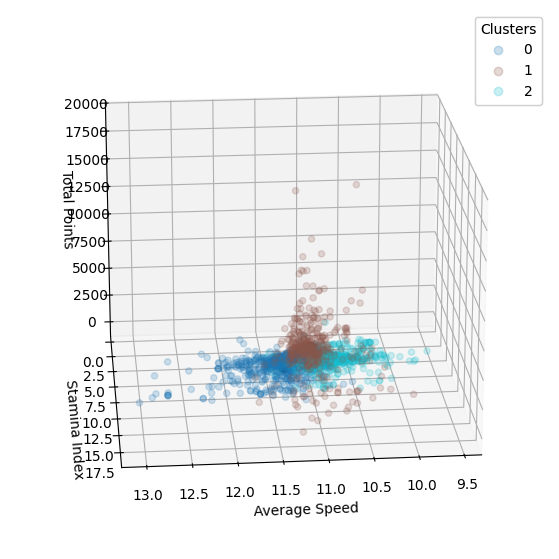

In [171]:
# 3D scatter plot with centers
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

X = 'avg_speed_cyclist'
X_NAME = 'Average Speed'
Y = 'stamina_index'
Y_NAME = 'Stamina Index'
Z = 'total_points'
Z_NAME = 'Total Points'

# Scatter plot
scatter = ax.scatter(small_cyc_df[X], 
                     small_cyc_df[Y], 
                     small_cyc_df[Z], 
                     c=small_cyc_df['cluster'], cmap='tab10', alpha=0.2)

# Plot centers
col = list(small_cyc_df.columns)
#print(col)
ax.scatter(centers[:, col.index(X)], centers[:, col.index(Y)], centers[:, col.index(Z)], c='black', s=100, alpha=1, label='Centers')
#print(centers)
# Labels
ax.set_xlabel(X_NAME)
ax.set_ylabel(Y_NAME)
ax.set_zlabel(Z_NAME)

# Rotate the plot
ax.view_init(elev=20, azim=85)  # Adjust the values as needed

# Legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

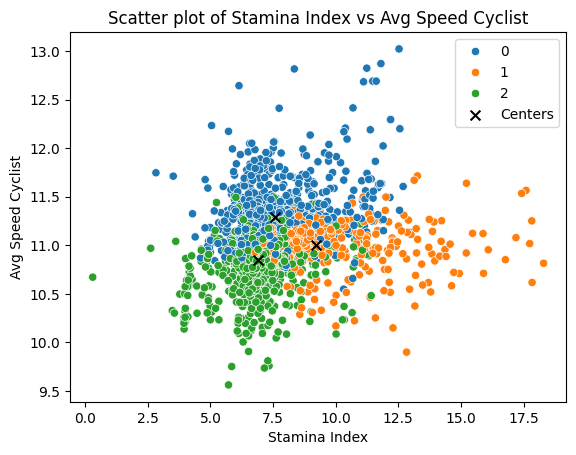

In [172]:

sns.scatterplot(data=small_cyc_df, x='stamina_index', y='avg_speed_cyclist', hue='cluster', palette='tab10')
plt.scatter(centers[:, 5], centers[:, 3], c='black', s=50, alpha=1, label='Centers', marker='x')
plt.title('Scatter plot of Stamina Index vs Avg Speed Cyclist')
plt.xlabel('Stamina Index')
plt.ylabel('Avg Speed Cyclist')
plt.legend()
plt.show()

## Different initialization methods

### kmeans ++

We're really lucky that sklearn give us the possibility to use kmeans++ with just a flag, we'll forever be grateful to the grat programmers...

In [173]:
columns_to_remove = ['height', 'weight', 
                    'victories_by_points', 'avg_points_per_race', 'average_position',
                    'birth_year', # I forgot age was dependent from this and I was puzled by the presence of a straight line
                    'cluster'
]
small_cyc_df = cyclysts_df.drop(columns=columns_to_remove)
cyc_normalizer, cyc_normalized = scale_data(small_cyc_df)
print(small_cyc_df.columns)

Index(['bmi', 'race_count', 'total_points', 'avg_speed_cyclist', 'cyclist_age',
       'stamina_index'],
      dtype='object')


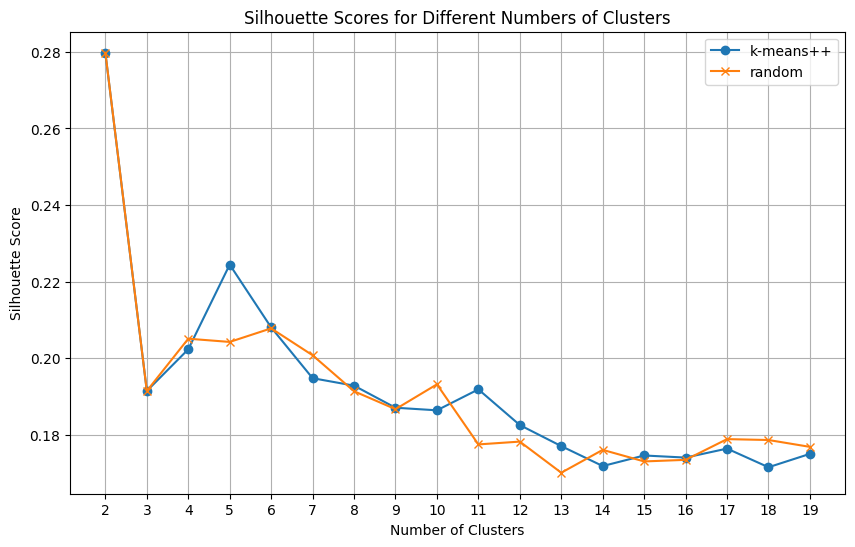

In [174]:
MAX_CLUSTERS = 20   # all the cluster numbers we want to try (from 2 to MAX_CLUSTERS)
N_INIT = 3         # Number of time the k-means algorithm will be run with different centroid seeds.
if RUN_SLOW_STUFF:
    silhouettes_plus = k_search(max_clusters=MAX_CLUSTERS, n_init=N_INIT, data=cyc_normalized, init_method='k-means++')
    silhouettes_random = k_search(max_clusters=MAX_CLUSTERS, n_init=N_INIT, data=cyc_normalized, init_method='random')

    # Plot the silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, MAX_CLUSTERS), silhouettes_plus, marker='o', label='k-means++')
    plt.plot(range(2, MAX_CLUSTERS), silhouettes_random, marker='x', label='random')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.xticks(range(2, MAX_CLUSTERS))  # Set x-axis ticks to be integers
    plt.legend()
    plt.grid(True)
    plt.show()

In [175]:
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=N_INIT, init='k-means++')
kmeans.fit(cyc_normalized)
small_cyc_df['cluster'] = kmeans.labels_
centers = cyc_normalizer.inverse_transform(kmeans.cluster_centers_)

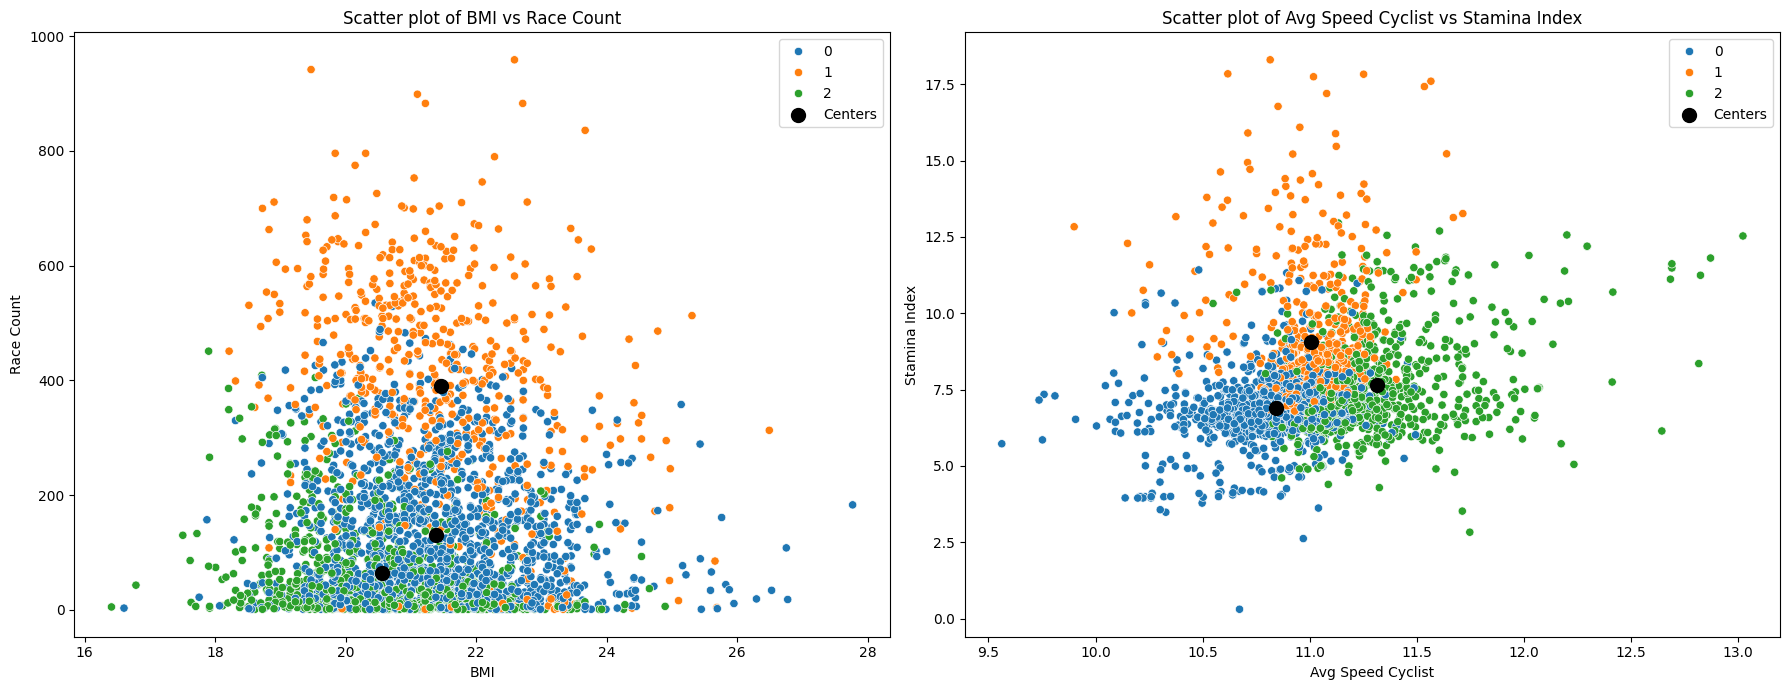

In [176]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# First plot
sns.scatterplot(data=small_cyc_df, x='bmi', y='race_count', hue='cluster', palette='tab10', ax=axes[0])
axes[0].scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=1, label='Centers')
axes[0].set_title('Scatter plot of BMI vs Race Count')
axes[0].set_xlabel('BMI')
axes[0].set_ylabel('Race Count')
axes[0].legend()

# Second plot
sns.scatterplot(data=small_cyc_df, x='avg_speed_cyclist', y='stamina_index', hue='cluster', palette='tab10', ax=axes[1])
axes[1].scatter(centers[:, 3], centers[:, 5], c='black', s=100, alpha=1, label='Centers')
axes[1].set_title('Scatter plot of Avg Speed Cyclist vs Stamina Index')
axes[1].set_xlabel('Avg Speed Cyclist')
axes[1].set_ylabel('Stamina Index')
axes[1].legend()

plt.tight_layout()
plt.show()

In [181]:
# Number of points in each cluster
cluster_counts = small_cyc_df['cluster'].value_counts().sort_index()
print("Number of points in each cluster:")
print(cluster_counts)

# Prototype (centroid) of each cluster
# Create a table with labels from small_cyc_df.columns
centroid_df = pd.DataFrame(centers, columns=small_cyc_df.columns[:-1])
centroid_df.index = [f'Cluster {i}' for i in range(len(centers))]

Number of points in each cluster:
cluster
0    1535
1     576
2     788
Name: count, dtype: int64


In [182]:
centroid_df

bmi  race_count  total_points  avg_speed_cyclist  \
Cluster 0  21.379221  130.482736    165.394788          10.841797   
Cluster 1  21.456400  391.104167   2200.144097          11.005623   
Cluster 2  20.563096   64.784264    148.545685          11.312246   

           cyclist_age  stamina_index  
Cluster 0    41.095114       6.879629  
Cluster 1    49.869792       9.054421  
Cluster 2    29.893401       7.640823

### Considerations on the clustering for the cyclists dataset

**About initializzation**

They are basically the same, also testing with differentnumber of initializzation, up to 15 inizialization. This is probably because the problem is simple and data are positioned in a way that make all the cluster to separate in a preferred way. Explaining better: looking at the datapoints from various angles, we can see by eye that it looks like there is only one cluster. For this reason also random initialization is a good choice. 

**About the clusters**

To be discussed with other group members

The clusters seem reasonable, but it is pretty hard to assign a meaning to a particular assignement if not the obvious one. we can observe 3 cluster (decision taken looking at the elbow) (note, colors are not deterministic remember to check them before delivery)
- 1 orange      any  avg_speed | high stamina | high race_count | high tot_pont | any BMI
- 2 blue        low  avg_speed | any  stamina | any  race_count | any  tot_pont | any BMI
- 3 green       high avg_speed | any  stamina | any  race_count | any  tot_pont | any BMI

observing the values of the centroids we can say that in general, the blu cyclist (cluster 0) are the most of the mass, and they are all in one cluster that has size that is more than the sum of the other two, they also seem to be "the average cyclist" because most of its values are in between the values of the other 2 clusters, but the average speed and stamina index are lower. (an evaluation should be done by a domain expert not by me, I use the bike only to go to the beach)

# Races dataset

In [184]:
# As always we start by importing the necessary libraries
# and loading the data we will be working with.
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# this is a classic
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from utility.cluster_utility import scale_data, inverse_scale_data
from utility.cluster_utility import k_search


# we define a random state to make the results reproducible
RANDOM_STATE = 42
RUN_SLOW_STUFF = True

races_df = pd.read_csv('../dataset/races_cleaned.csv')
races_df = races_df.groupby('_url').first().reset_index()
print(races_df.columns)

Index(['_url', 'name', 'stage', 'stage_type', 'points', 'uci_points', 'length',
       'climb_total', 'profile', 'startlist_quality', 'date', 'position',
       'cyclist', 'cyclist_age', 'is_tarmac', 'delta', 'time', 'time_seconds',
       'average_speed', 'steepness', 'season', 'is_staged', 'race_country',
       'norm_points', 'age_performance_index', 'quality_adjusted_points',
       'normalized_length', 'normalized_quality', 'normalized_steepness',
       'normalized_time', 'stamina_index', 'length_category'],
      dtype='object')


In [ ]:
# TO DROP OR NOT TO DROP
# some that are too correlated to others [uci_points, quality_adjusted_points]
# some that just don't make sense [position, delta, cyclist_age, age_performance_index]
# some that are actually cathegorical [profile, season]
# some that are the normalization of other columns [norm_points, normalized_length, normalized_quality, normalized_steepness]
columns_to_drop = [
    '_url', 'name', 'stage', 'stage_type', 'race_country', # strings or cathegorical
    'uci_points', 'quality_adjusted_points', 'steepness', # correlated to other columns
    'time','time_seconds', 'normalized_time', # Time related
    'position', 'delta', 'cyclist_age', 'age_performance_index', 'stamina_index', 'cyclist', 'age_performance_index', # stuff of the cyclist
    'profile', 'season', 'is_staged', 'is_tarmac', 'length_category', # cathegorical
    'norm_points', 'normalized_length', 'normalized_quality', 'normalized_steepness' # normalization of other columns
]
races_df = races_df[races_df['average_speed'] < 60]
races_df_small = races_df.drop(columns=columns_to_drop)

# drop any remaining columns that are not numerical
races_df_small = races_df_small.select_dtypes(include=[np.number])
# drop the rows with missing values
initial_count = races_df_small.shape[0]
races_df_small = races_df_small.dropna()

final_count = races_df_small.shape[0]
print(f'Dropped {initial_count - final_count} rows with missing values')
print(f'In percentage: {(initial_count - final_count) / initial_count * 100}%')
print(races_df_small.columns)

Dropped 2127 rows with missing values
In percentage: 43.855670103092784%
Index(['points', 'length', 'climb_total', 'startlist_quality',
       'average_speed'],
      dtype='object')


In [186]:
race_normalizer, race_normalized = scale_data(races_df_small)

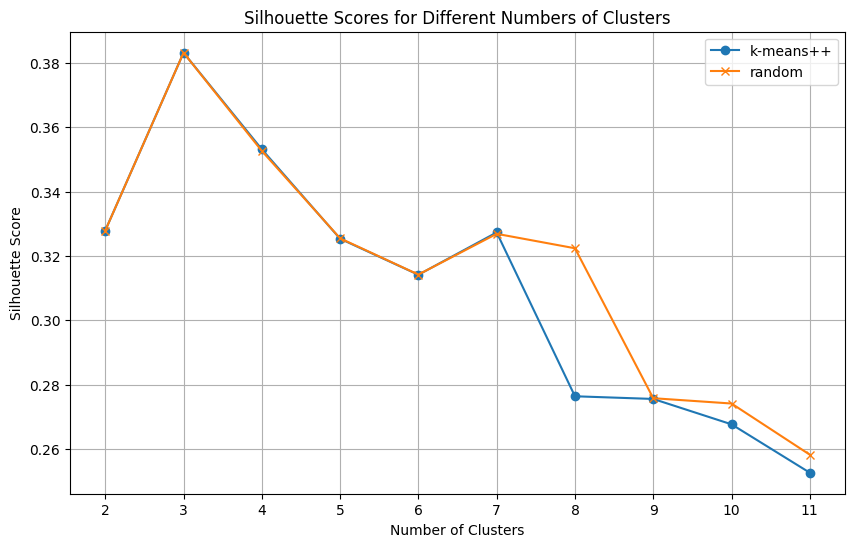

In [187]:
MAX_CLUSTERS = 12   # all the cluster numbers we want to try (from 2 to MAX_CLUSTERS)
N_INIT = 5          # Number of time the k-means algorithm will be run with different centroid seeds.
if RUN_SLOW_STUFF:
    silhouettes_plus = k_search(max_clusters=MAX_CLUSTERS, n_init=N_INIT, data=race_normalized, init_method='k-means++')
    silhouettes_random = k_search(max_clusters=MAX_CLUSTERS, n_init=N_INIT, data=race_normalized, init_method='random')

    # Plot the silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, MAX_CLUSTERS), silhouettes_plus, marker='o', label='k-means++')
    plt.plot(range(2, MAX_CLUSTERS), silhouettes_random, marker='x', label='random')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.xticks(range(2, MAX_CLUSTERS))  # Set x-axis ticks to be integers
    plt.legend()
    plt.grid(True)
    plt.show()

Sta cosa dell'inizializzazione e' tutta una farsa prendiamo 6 centroidi

In [188]:
kmeans = KMeans(n_clusters=6, random_state=RANDOM_STATE, n_init=N_INIT, init='k-means++')
kmeans.fit(race_normalized)
races_df_small['cluster'] = kmeans.labels_
centers = race_normalizer.inverse_transform(kmeans.cluster_centers_)

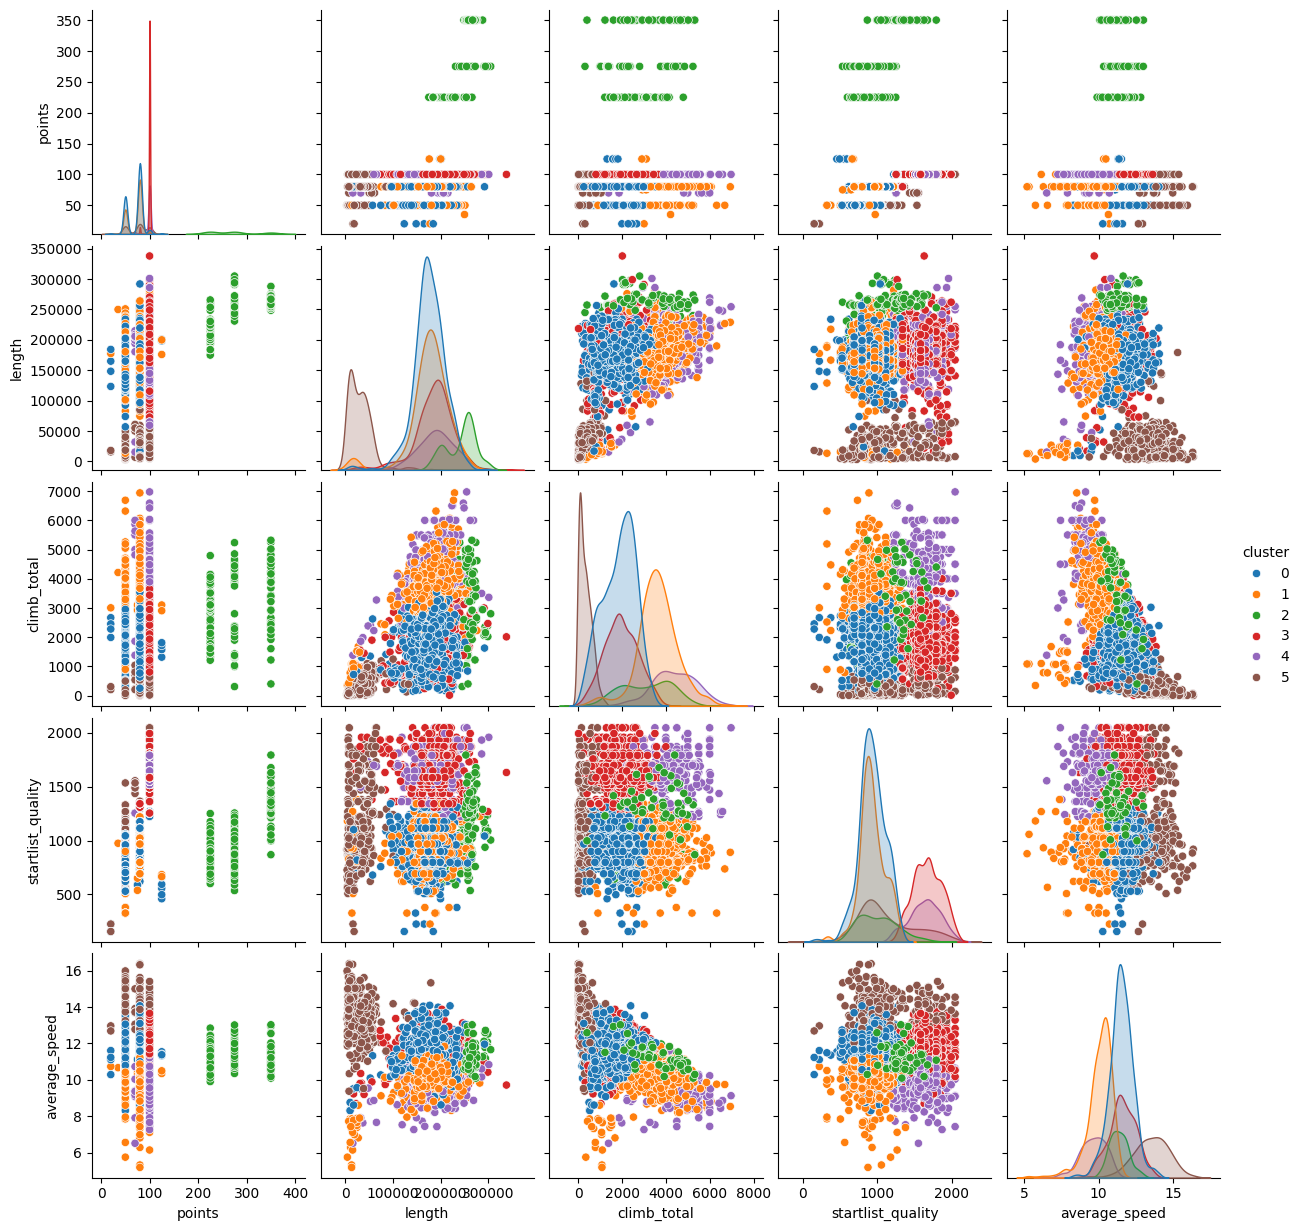

In [189]:
pairplot = sns.pairplot(races_df_small, hue='cluster', palette='tab10')
plt.show()

This shows that the races with high points are in a class by themself, and also, although the feature should be a natural number takes verry few values, so we can try to see if we have more interesting clusters by removing the `points` column. since 6 centroids are a analyze by just looking at the plot we can see if they are correlated with some other feaures we removed before running the algorithm. 

## Analysis

In [ ]:
# are brown ITT

## Removing points

In [190]:
races_df_small = races_df_small.drop(columns=['cluster', 'points'])
race_normalizer, race_normalized = scale_data(races_df_small)

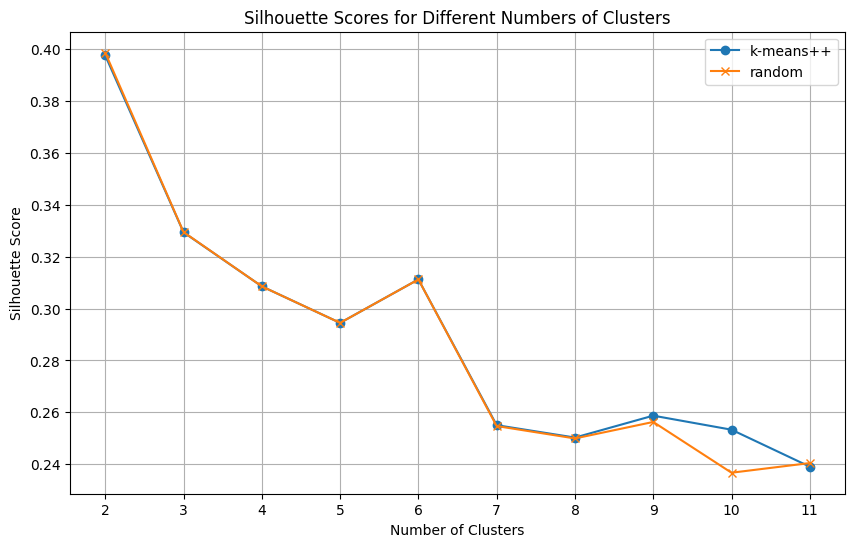

In [191]:
MAX_CLUSTERS = 12   # all the cluster numbers we want to try (from 2 to MAX_CLUSTERS)
N_INIT = 5          # Number of time the k-means algorithm will be run with different centroid seeds.
if RUN_SLOW_STUFF:
    silhouettes_plus = k_search(max_clusters=MAX_CLUSTERS, n_init=N_INIT, data=race_normalized, init_method='k-means++')
    silhouettes_random = k_search(max_clusters=MAX_CLUSTERS, n_init=N_INIT, data=race_normalized, init_method='random')

    # Plot the silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, MAX_CLUSTERS), silhouettes_plus, marker='o', label='k-means++')
    plt.plot(range(2, MAX_CLUSTERS), silhouettes_random, marker='x', label='random')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.xticks(range(2, MAX_CLUSTERS))  # Set x-axis ticks to be integers
    plt.legend()
    plt.grid(True)
    plt.show()

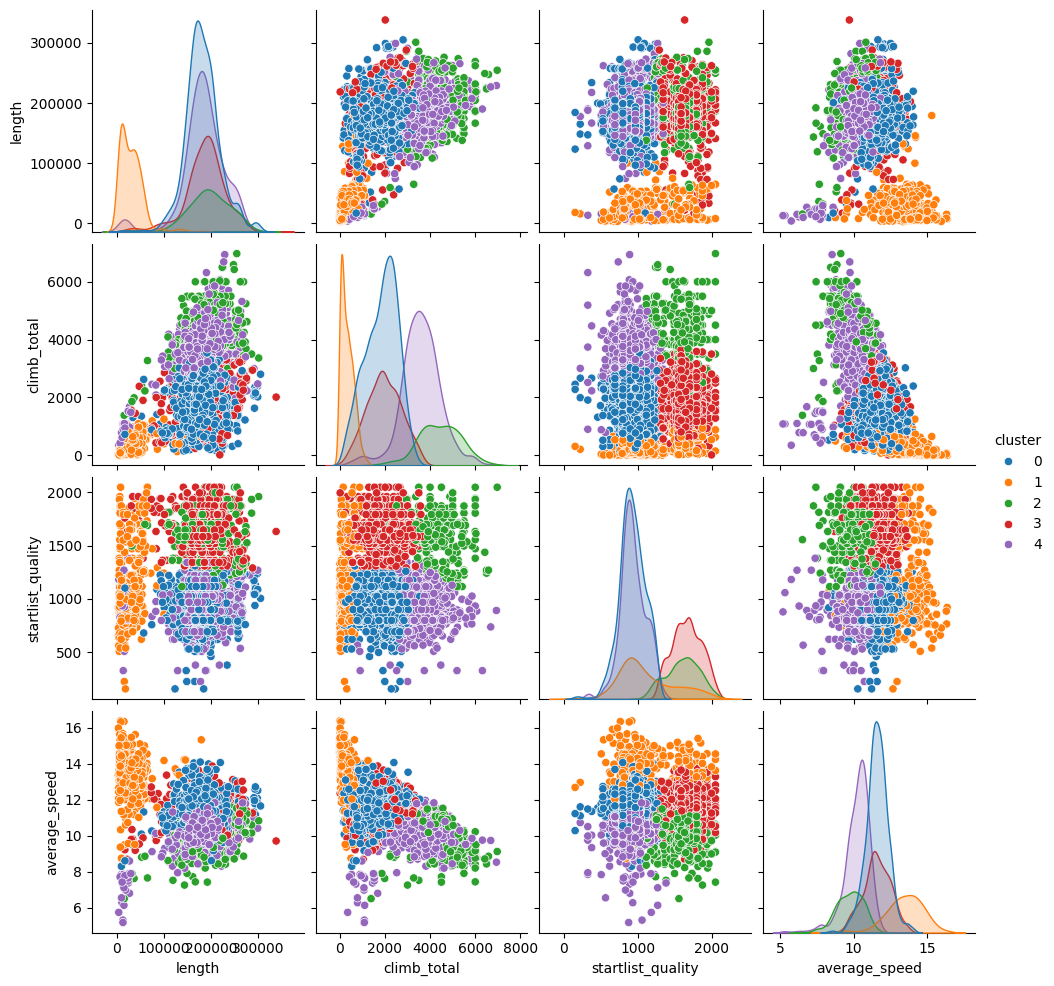

In [193]:
kmeans = KMeans(n_clusters=5, random_state=RANDOM_STATE, n_init=N_INIT, init='k-means++')
kmeans.fit(race_normalized)
races_df_small['cluster'] = kmeans.labels_
centers = race_normalizer.inverse_transform(kmeans.cluster_centers_)
pairplot = sns.pairplot(races_df_small, hue='cluster', palette='tab10')
plt.show()

are they divided by difficulty?

In [208]:
# Merge Merge the the cluster cluster labels labels with with the the original original dataset dataset
merged_df = small_cyc_df.merge(races_df, left_index=True, right_index=True)
columns_to_correlate = ['cluster', 'stage_type', 'points', 'profile', 'is_tarmac', 'season', 'is_staged']
columns_to_analyze = ['race_country']
merged_df = merged_df[columns_to_correlate]
merged_df['stage_type'] = merged_df['stage_type'].apply(lambda x: 1 if x == 'RR' else 0)
merged_df['season'] = merged_df['season'].astype('category')

correlation_spearman = merged_df.corr(method='spearman')['cluster']
correlation_pearson = merged_df.corr(method='pearson')['cluster']
correlation_kendall = merged_df.corr(method='kendall')['cluster']
print('Feature   \t\tSpearman\tPearson\t\tKendall')
for i in merged_df.columns:
    feat = i.ljust(10)
    print(f'{feat}\t\t{correlation_spearman[i]:.4f}\t\t{correlation_pearson[i]:.4f}\t\t{correlation_kendall[i]:.4f}')
    

Feature   		Spearman	Pearson		Kendall
cluster   		1.0000		1.0000		1.0000
stage_type		0.0056		0.0079		0.0053
points    		-0.0347		-0.0367		-0.0302
profile   		-0.0391		-0.0330		-0.0334
is_tarmac 		0.0275		0.0256		0.0262
season    		0.0141		0.0015		0.0127
is_staged 		0.0275		0.0256		0.0262


Well not too much correlation here but it's okay. In realta' non mi torna, cioe' alcuni cluster contengono chiaramente le ITT e gli altri le RR, devo capire con gli altri

Cosa vedo come divisione
- Le gare corte la cui velocita' e' alta sono arancioni
- gli altri 4 gruppi dividono in 4 lo spazio visto da climb total e startlist_quality